In [2]:
# Load tensors.pkl and assign variables with their original names
import os
import pickle
import numpy as np

FNAME = "tensors.pkl"

# Whitelist of expected keys (prevents accidental injection of unwanted names)
EXPECTED_KEYS = [
    "tensorNEP_rewarded100pp",
    "tensorNEP_rewarded500pp",
    "tensorNEP_rewarded100hp",
    "tensorNEP_rewarded500hp",
    "tensorNEP_all100pp",
    "tensorNEP_all500pp",
    "tensorNEP_all100hp",
    "tensorNEP_all500hp",
    "tensorTE_filt_100pp",
    "tensorTE_filt_500pp",
    "tensorTE_filt_100hp",
    "tensorTE_filt_500hp",
    "tensorTE_filt_100pp_rewarded",
    "tensorTE_filt_100hp_rewarded",
    "reward_arms",
    "speed",
    "event_intervals_ms",
    "mat_100pp_spikefiltered",
    "mat_100hp_spikefiltered",
    "event_arm_ids_rewarded",
    "event_arm_ids",
]

def _brief(obj):
    """Make a short description for summary printing."""
    try:
        import pandas as pd  # only used if available
    except Exception:
        pd = None

    if isinstance(obj, np.ndarray):
        return f"ndarray shape={obj.shape}, dtype={obj.dtype}"
    if pd is not None and isinstance(obj, (pd.DataFrame, pd.Series)):
        if hasattr(obj, "shape"):
            return f"{type(obj).__name__} shape={obj.shape}"
        return type(obj).__name__
    if isinstance(obj, (list, tuple, set)):
        return f"{type(obj).__name__} len={len(obj)}"
    if isinstance(obj, dict):
        return f"dict keys={len(obj)}"
    return type(obj).__name__

if not os.path.exists(FNAME):
    raise FileNotFoundError(f"File not found: {FNAME}")

with open(FNAME, "rb") as f:
    data = pickle.load(f)

if not isinstance(data, dict):
    raise ValueError("Pickle content is not a dict of named objects.")

# Assign only expected keys to the global namespace
loaded, missing = [], []
for key in EXPECTED_KEYS:
    if key in data:
        globals()[key] = data[key]
        loaded.append(key)
    else:
        missing.append(key)

# Warn about unexpected extra keys (we don't auto-load them for safety)
extra = sorted(set(data.keys()) - set(EXPECTED_KEYS))

print(f"Loaded from {FNAME}: {len(loaded)} variables")
for k in loaded:
    print(f"  • {k}: {_brief(globals()[k])}")

if missing:
    print(f"\nMissing {len(missing)} expected key(s):")
    for k in missing:
        print(f"  - {k}")

if extra:
    print(f"\nFound {len(extra)} extra key(s) not in EXPECTED_KEYS (ignored for safety):")
    for k in extra:
        print(f"  - {k}")

Loaded from tensors.pkl: 21 variables
  • tensorNEP_rewarded100pp: ndarray shape=(399, 133, 140), dtype=float32
  • tensorNEP_rewarded500pp: ndarray shape=(399, 133, 140), dtype=float32
  • tensorNEP_rewarded100hp: ndarray shape=(40, 133, 140), dtype=float32
  • tensorNEP_rewarded500hp: ndarray shape=(40, 133, 140), dtype=float32
  • tensorNEP_all100pp: ndarray shape=(399, 180, 140), dtype=float32
  • tensorNEP_all500pp: ndarray shape=(399, 180, 140), dtype=float32
  • tensorNEP_all100hp: ndarray shape=(40, 180, 140), dtype=float32
  • tensorNEP_all500hp: ndarray shape=(40, 180, 140), dtype=float32
  • tensorTE_filt_100pp: ndarray shape=(373, 64, 180), dtype=float64
  • tensorTE_filt_500pp: ndarray shape=(376, 14, 180), dtype=float64
  • tensorTE_filt_100hp: ndarray shape=(40, 64, 180), dtype=float64
  • tensorTE_filt_500hp: ndarray shape=(40, 14, 180), dtype=float64
  • tensorTE_filt_100pp_rewarded: ndarray shape=(373, 64, 133), dtype=float64
  • tensorTE_filt_100hp_rewarded: ndarray 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import slicetca
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


# Run SliceTCA on (neurons × events × positions)
def apply_slicetca(neural_data, event_arm_ids, rank=(1, 1, 1), positive=True, device="cpu", label='position'):
    """
    Apply SliceTCA decomposition to a tensor (neurons × events × positions).

    Parameters
    ----------
    tensor_sorted : np.ndarray
        Neural tensor (events x neurons × positions) or (events x neurons × time bins).
    rank : tuple
        Number of components for (events, neurons, positions).
    device : str
        "cuda" if GPU is available, else "cpu".
    label : str
        "time" if the last dimension of the entry tensor indicates time bins, else "position" is assumed.

    Returns
    -------
    components : list
        SliceTCA components.
    model : slicetca.SliceTCA
        Fitted model.
    """
    import os
    folder = os.path.expanduser("~/plots")
    os.makedirs(folder, exist_ok=True)

    # ROBUST PER-EVENT MIN-MAX NORMALIZATION 
    neural_data = np.asarray(neural_data)
    eps = 1e-8  # small constant to make divisions safe
    data_min = neural_data.min(axis=(1, 2), keepdims=True)          # per-event min
    shifted = neural_data - data_min                                 # shift to start at 0
    data_max = shifted.max(axis=(1, 2), keepdims=True)               # per-event (shifted) max
    neural_data = shifted / (data_max + eps)                         # scale to [0,1] safely
    
    print('dimensions of neural data (trials, neurons, time bins):\t\t', neural_data.shape)

    tensor_torch = torch.tensor(neural_data, dtype=torch.float32, device=device)

    # Extra safety: if global std == 0, skip division to avoid NaNs.
    # (This keeps behavior similar to your original line but robust.)
    global_std = tensor_torch.std()
    if float(global_std) > 0:
        tensor_torch = tensor_torch / global_std

    components, model = slicetca.decompose(tensor_torch, number_components=rank, positive=positive,
        learning_rate=5e-3, min_std=1e-5, max_iter=10000, seed=0)

    if positive:
        model = slicetca.invariance(model)

    # Order events by arm_id (POST-DECOMPOSITION!)
    sort_idx = np.argsort(event_arm_ids)  # indices to sort original events by arm
    arm_list_sorted = event_arm_ids[sort_idx]
    
    # Define colors for sorted events
    cmap = plt.colormaps["tab10"]
    unique_arms_sorted = np.unique(arm_list_sorted)
    arm_to_color = {arm_id: cmap(i % 10)[:3] for i, arm_id in enumerate(unique_arms_sorted)}
    event_colors_sorted = np.array([arm_to_color[arm_id] for arm_id in arm_list_sorted])
    
    # DEFINE COLORS FOR NON-SORTED EVENTS
    cmap = plt.colormaps["tab10"]
    unique_arms = np.unique(event_arm_ids)
    arm_to_color = {arm_id: cmap(i % 10)[:3] for i, arm_id in enumerate(unique_arms)}
    event_colors = np.array([arm_to_color[arm_id] for arm_id in event_arm_ids])
    
    # NEURON & EVENT SORTING 
    neuron_sorting = np.argsort(np.argmax(components[0][1][0], axis=1))
    event_sorting = sort_idx  
    
    # FINAL PLOTS 
    # non-sorted plot
    axes1 = slicetca.plot(model,
        variables=('events', 'neuron', label),
        colors=(event_colors, None, None),
        sorting_indices=(None, neuron_sorting, None),
        quantile=0.99)
    plt.savefig(f"{folder}/slicetca_nonsorted.png")
    plt.show()
    
    
    # sorted plot
    axes2 = slicetca.plot(model,
        variables=('events', 'neuron', label),
        colors=(event_colors_sorted, None, None),
        sorting_indices=(event_sorting, neuron_sorting, None),  
        quantile=0.99)
    plt.savefig(f"{folder}/slicetca_sorted.png")
    plt.show()

    return components, model, neural_data

In [15]:
event_arm_ids = np.asarray(event_arm_ids, dtype=int)
event_arm_ids_rewarded = np.asarray(event_arm_ids_rewarded, dtype=int)

dimensions of neural data (trials, neurons, time bins):		 (180, 40, 64)


The model converged. Loss: 0.12333626300096512 :  38%|▍| 3817/10000 [16:44<2
The invariance converged. Invariance loss: 0.7391660809516907 :   6%| | 606/


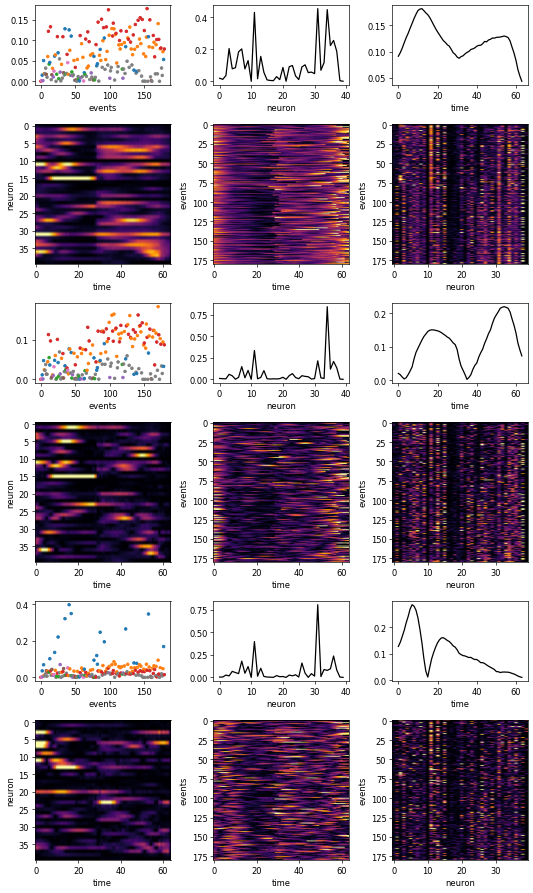

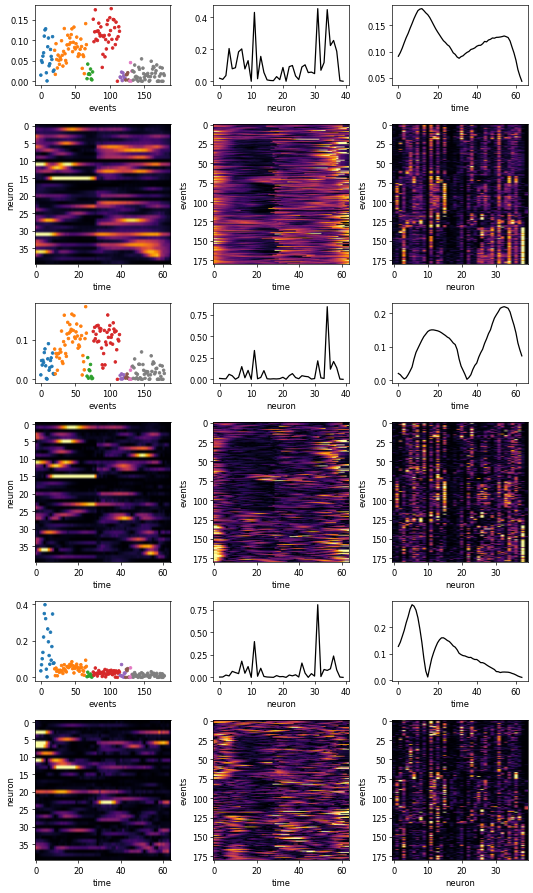

In [7]:
tensor_nte_100hp_all = np.transpose(tensorTE_filt_100hp, (2, 0, 1))
components100hp_all, model_100hp_all, neural_data = apply_slicetca(tensor_nte_100hp_all , event_arm_ids, rank=(3, 3, 3), positive=True, device="cpu", label='time')

dimensions of neural data (trials, neurons, time bins):		 (133, 40, 64)


The model converged. Loss: 0.09739203006029129 :  61%|▌| 6082/10000 [00:56<0
The invariance converged. Invariance loss: 0.6946413516998291 :   6%| | 633/


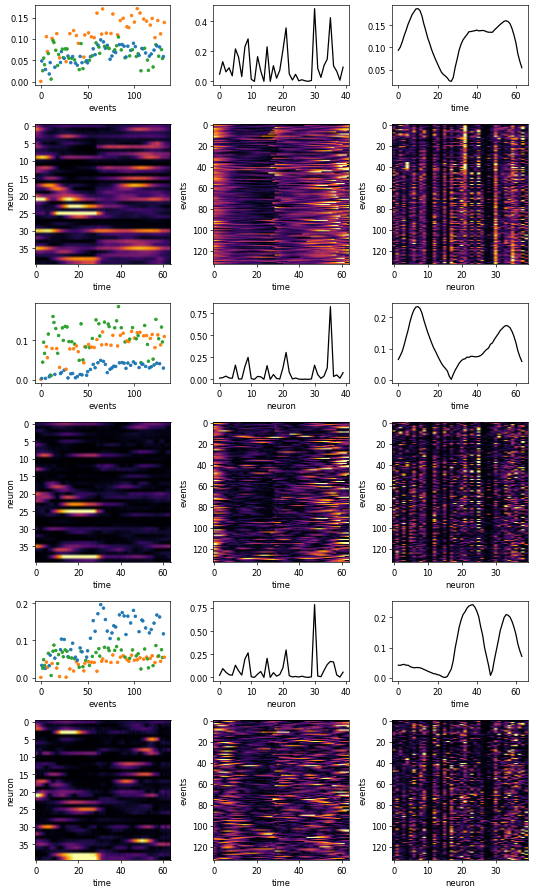

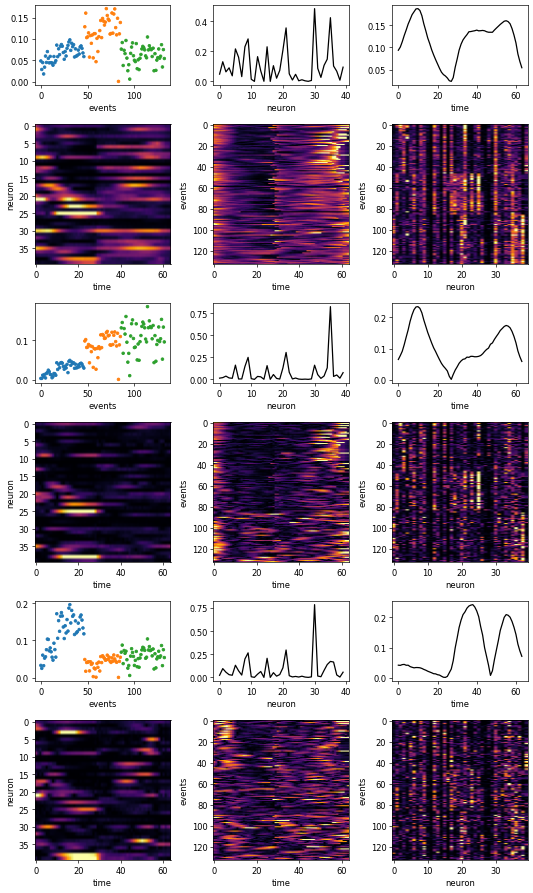

In [16]:
tensor_nte_100hp_rewarded = np.transpose(tensorTE_filt_100hp_rewarded, (2, 0, 1))
components100hp_rewarded, model_100hp_rewarded, neural_data = apply_slicetca(tensor_nte_100hp_rewarded , event_arm_ids_rewarded, rank=(3, 3, 3), positive=True, device="cpu", label='time')

dimensions of neural data (trials, neurons, time bins):		 (180, 373, 64)


The model converged. Loss: 0.09910117089748383 :  32%|▎| 3226/10000 [06:03<1
The invariance converged. Invariance loss: 0.5664546489715576 :   6%| | 632/


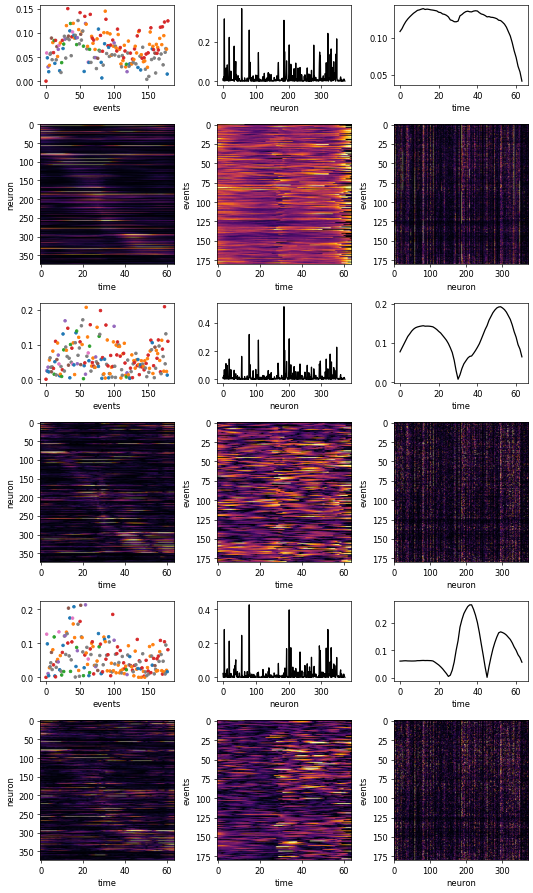

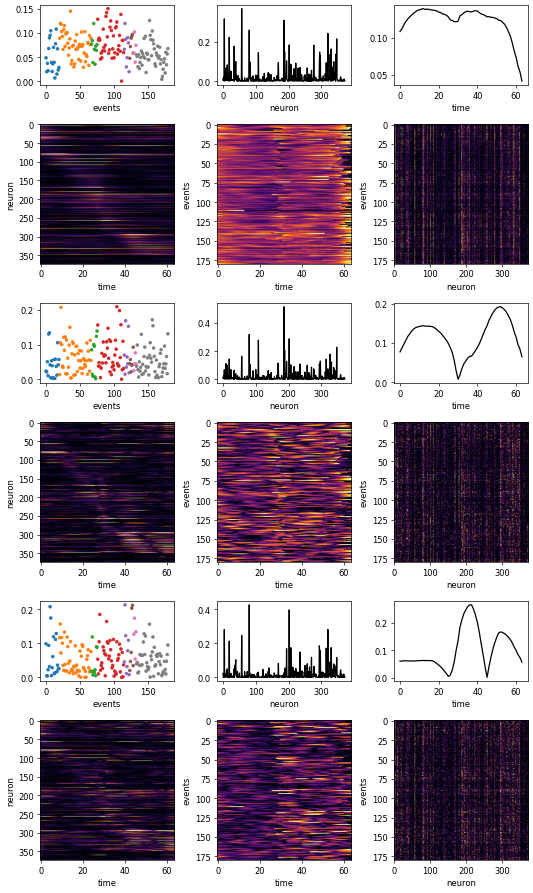

In [17]:
tensor_nte_100pp_all = np.transpose(tensorTE_filt_100pp, (2, 0, 1))
components100pp_all, model_100pp_all, neural_data = apply_slicetca(tensor_nte_100pp_all, event_arm_ids, rank=(3, 3, 3), positive=True, device="cpu", label='time')

dimensions of neural data (trials, neurons, time bins):		 (133, 373, 64)


The model converged. Loss: 0.09958662837743759 :  48%|▍| 4785/10000 [06:32<0
The invariance converged. Invariance loss: 0.5750632286071777 :   7%| | 658/


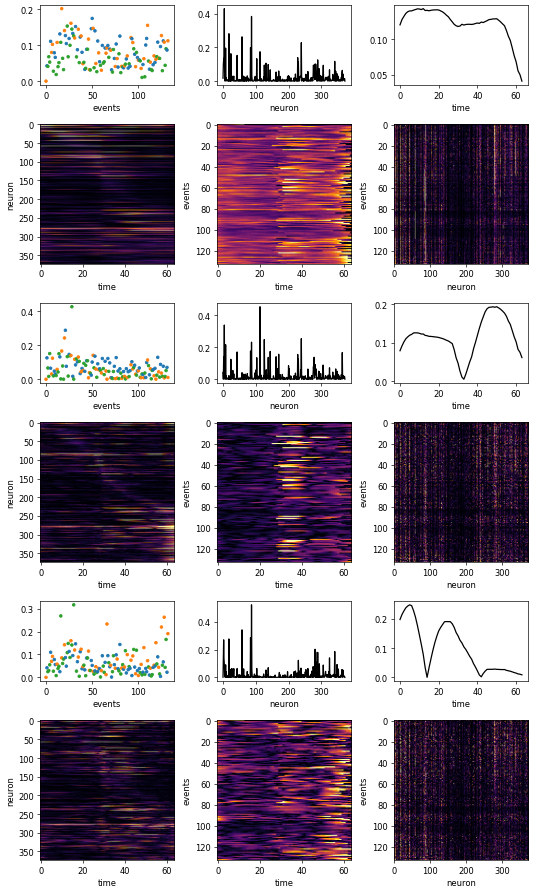

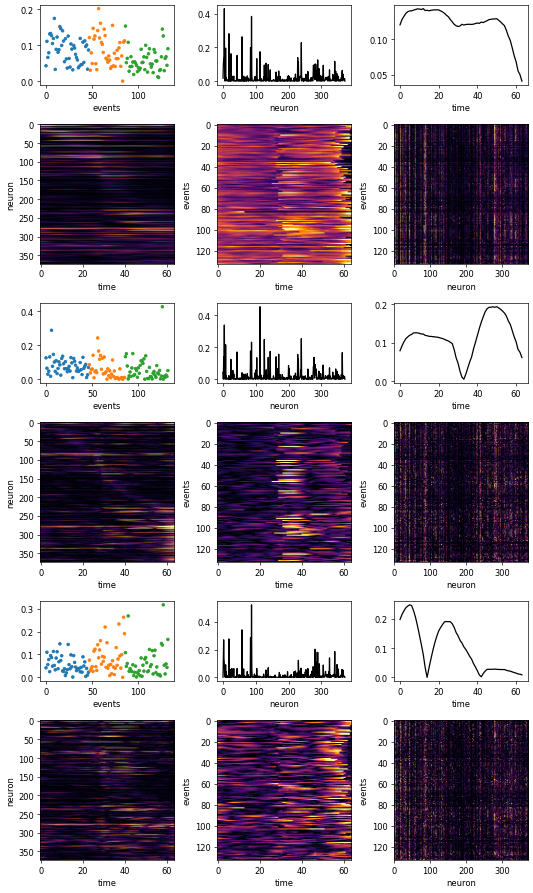

In [18]:
tensor_nte_100pp_rewarded = np.transpose(tensorTE_filt_100pp_rewarded, (2, 0, 1))
components100hp_rewarded, model_100hp_rewarded, neural_data = apply_slicetca(tensor_nte_100pp_rewarded , event_arm_ids_rewarded, rank=(3, 3, 3), positive=True, device="cpu", label='time')

dimensions of neural data (trials, neurons, time bins):		 (133, 40, 140)


The model converged. Loss: 0.2055220752954483 :  29%|▎| 2927/10000 [00:41<01
The invariance converged. Invariance loss: 0.6627880334854126 :   6%| | 592/


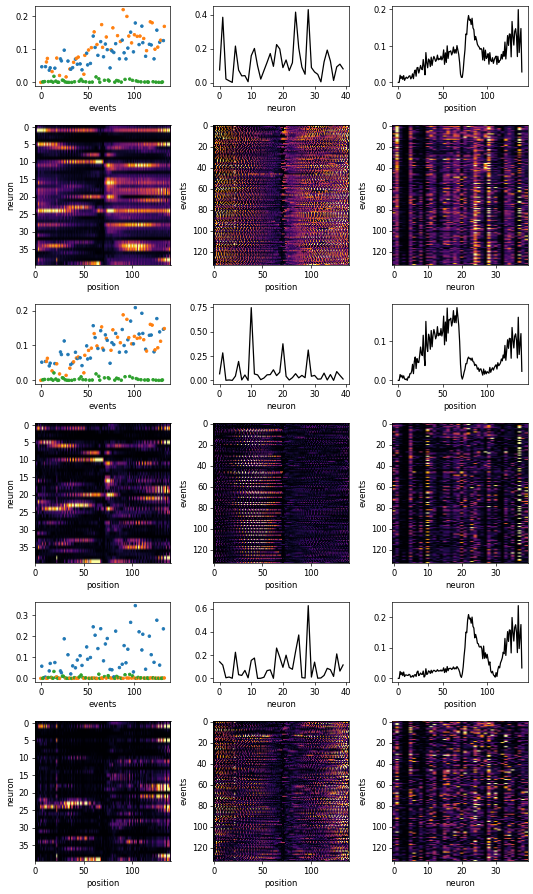

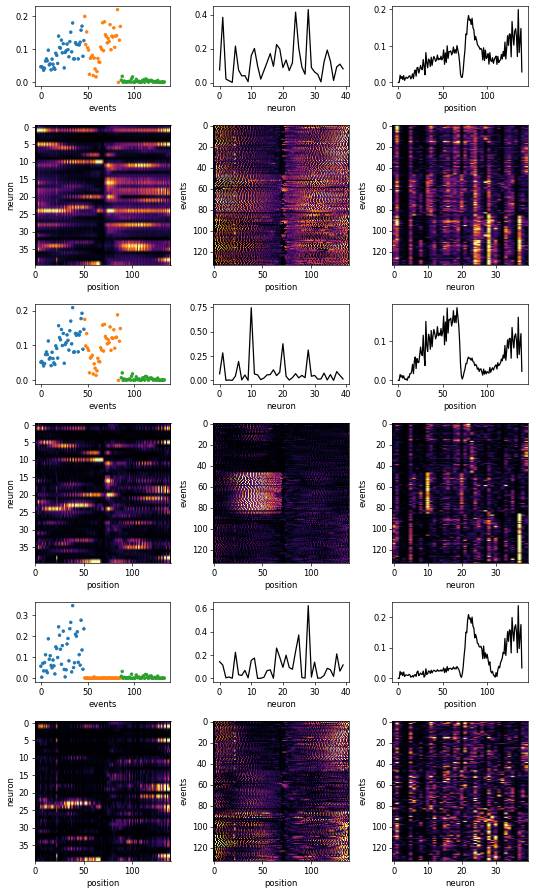

In [19]:
tensor_evp100hp = np.transpose(tensorNEP_rewarded100hp, (1, 0, 2))
components100hp, model, neural_data = apply_slicetca(tensor_evp100hp, event_arm_ids_rewarded, rank=(3, 3, 3), positive=True, device="cpu")

dimensions of neural data (trials, neurons, time bins):		 (133, 399, 140)


The model converged. Loss: 0.20033136010169983 :  44%|▍| 4439/10000 [16:00<2
The invariance converged. Invariance loss: 0.5981392860412598 :   6%| | 595/


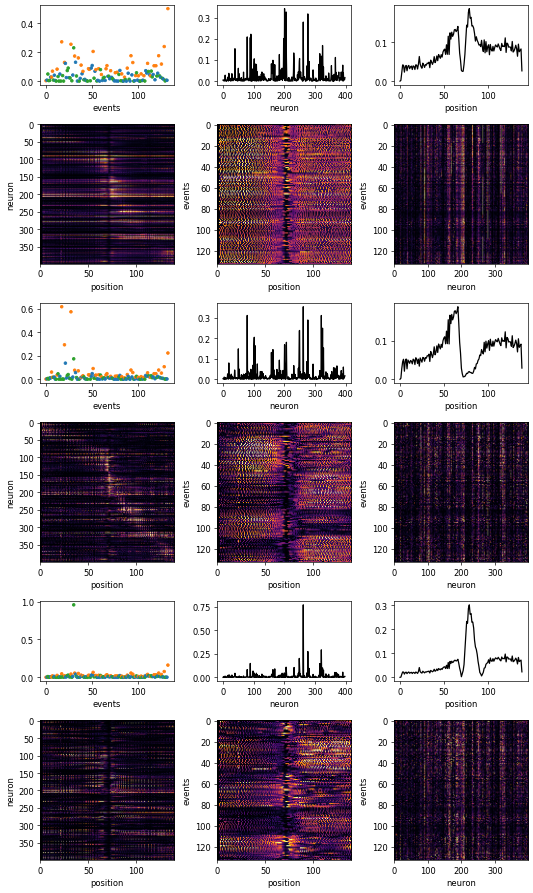

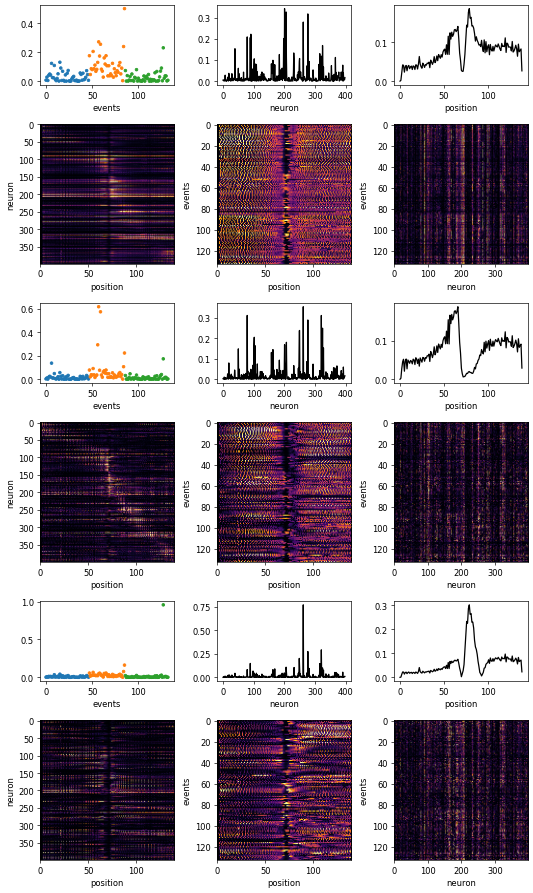

In [20]:
# (neurons, events, position) -> (events, neurons, position)
tensor_evp_100pp = np.transpose(tensorNEP_rewarded100pp, (1, 0, 2))
components, model, neural_data = apply_slicetca(tensor_evp_100pp, event_arm_ids_rewarded, rank=(3, 3, 3), positive=True, device="cpu")

dimensions of neural data (trials, neurons, time bins):		 (133, 399, 140)


The model converged. Loss: 0.16996502876281738 :  34%|▎| 3374/10000 [12:05<2


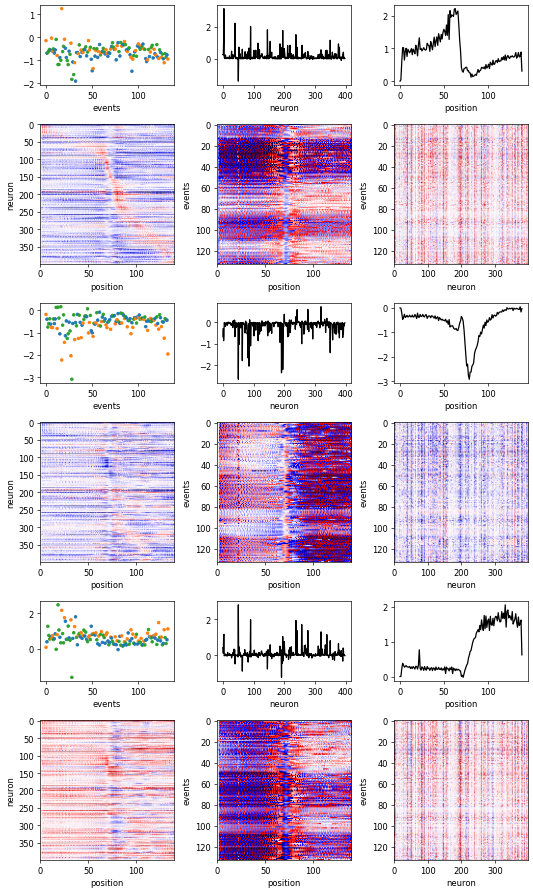

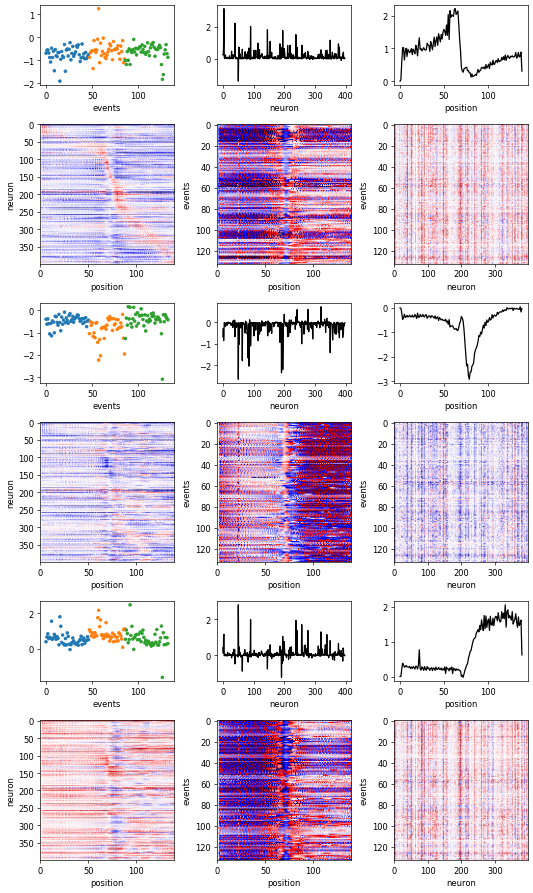

In [21]:
components3n, model3n, neural_data3n = apply_slicetca(tensor_evp_100pp, event_arm_ids_rewarded, rank=(3, 3, 3), positive=False, device="cpu")

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection)

def get_event_factors_slicetca(components):
    """
    Extract event/trial factors from SliceTCA output.

    Your SliceTCA layout (as provided):
      components[1][0] -> shape (R, N)
        - R: number of trial/event components (the rank for the "event" mode)
        - N: number of events

    For plotting, it's convenient to have shape (N, R).
    This function returns the transposed matrix: (N, R).
    """
    # Access the event factor matrix with shape (R, N)
    event_factors_RxN = components[0][0]
    event_factors_RxN = np.asarray(event_factors_RxN)
    if event_factors_RxN.ndim != 2:
        raise ValueError(f"Expected 2D event factors at components[1][0], got shape {event_factors_RxN.shape}")

    # Transpose to (N, R) = (n_events, n_components)
    event_factors_NxR = event_factors_RxN.T
    return event_factors_NxR


def plot_trial_components_3d_slicetca(components,
    event_colors,                 # array/list of length N_events with RGB/RGBA or valid color specs
    component_indices=(0, 1, 2),  # which three event components become (X, Y, Z) axes
    event_arm_ids=None,           # optional labels to overlay per-arm centroids (big "X" markers)
    title="SliceTCA trial/event components (3D)",
    save_path=None,               # e.g. "~/plots/trial_components_3d.png"
    elev=22, azim=38,             # camera angles
    point_size=28, alpha=0.95,    # aesthetics for points
    centroid_size=180,            # size for centroid markers
    show=True):
    """
    Plot all trial/event components from SliceTCA together in a single 3D scatter.

    Workflow
    --------
    1) Pull event factors from components[1][0] (shape R x N), transpose to (N x R).
    2) Choose three component indices (iX, iY, iZ) for axes.
    3) Scatter all events in 3D using your original per-event colors.
    4) (Optional) Overlay a centroid per arm_id to summarize cluster centers.

    Parameters
    ----------
    components : object
        SliceTCA 'components' structure containing event factors at components[1][0] with shape (R, N).
    event_colors : array-like
        Colors for each event (N items). Same order as your 2D plot.
        Accepts list of Matplotlib color specs or an (N x 3/4) numeric array.
    component_indices : tuple of int
        Indices of event components to map to (X, Y, Z). Example: (0, 1, 2).
    event_arm_ids : array-like, optional
        If provided, per-arm centroids are drawn as large "X" markers at the mean (X,Y,Z)
        of each arm's events. This helps spot cluster centers at a glance.
    title : str
        Plot title.
    save_path : str or None
        If provided, saves the figure to this path (folders created if needed).
    elev, azim : float
        3D view angles in degrees.
    point_size : int
        Size of points for the events.
    alpha : float
        Transparency for the event points.
    centroid_size : int
        Size for centroid markers (if event_arm_ids is provided).
    show : bool
        If True, calls plt.show() at the end.

    Returns
    -------
    coords_3d : np.ndarray, shape (N, 3)
        3D coordinates of each event in the chosen component space.
    """
    # --- 1) Extract (N, R) event factor matrix from your SliceTCA components ---
    event_factors = get_event_factors_slicetca(components)  # shape (N, R)
    n_events, n_components = event_factors.shape

    # --- 2) Validate component indices ---
    if len(component_indices) != 3:
        raise ValueError("component_indices must be a tuple of exactly three integers, e.g., (0, 1, 2).")
    iX, iY, iZ = component_indices
    for i in (iX, iY, iZ):
        if not (0 <= i < n_components):
            raise ValueError(f"Component index {i} is out of range [0, {n_components-1}].")

    # --- 3) Prepare coordinates and colors ---
    X = event_factors[:, iX]
    Y = event_factors[:, iY]
    Z = event_factors[:, iZ]
    coords_3d = np.column_stack([X, Y, Z])

    event_colors = np.asarray(event_colors)
    if len(event_colors) != n_events:
        raise ValueError(f"event_colors length ({len(event_colors)}) != number of events ({n_events}).")

    # --- 4) Build the 3D scatter plot ---
    fig = plt.figure(figsize=(8.5, 6.8))
    ax = fig.add_subplot(111, projection="3d")
    ax.view_init(elev=elev, azim=azim)

    # Scatter all events using the original per-event colors
    ax.scatter(coords_3d[:, 0], coords_3d[:, 1], coords_3d[:, 2], c=event_colors, s=point_size, alpha=alpha, depthshade=False)

    # --- 5) Optional: overlay per-arm centroids to summarize group locations ---
    # A centroid is the mean (x, y, z) of all events belonging to the same arm.
    if event_arm_ids is not None:
        event_arm_ids = np.asarray(event_arm_ids)
        if event_arm_ids.shape[0] != n_events:
            raise ValueError("event_arm_ids must have the same length as the number of events.")
        unique_arms = np.unique(event_arm_ids)
        for arm in unique_arms:
            idx = np.where(event_arm_ids == arm)[0]
            if idx.size == 0:
                continue
            cx, cy, cz = coords_3d[idx].mean(axis=0)
            # Use the group's first color so the centroid visually belongs to that cluster
            ax.scatter(cx, cy, cz, c=event_colors[idx[0]].reshape(1, -1),
                s=centroid_size, marker="X", edgecolors="k", linewidths=0.9)
            # Optional: label the centroid with the arm id (comment out if not desired)
            # ax.text(cx, cy, cz, str(arm), fontsize=9, ha="center", va="center")

    # Axis labels and title
    ax.set_xlabel(f"Event comp {iX+1}")
    ax.set_ylabel(f"Event comp {iY+1}")
    ax.set_zlabel(f"Event comp {iZ+1}")
    ax.set_title(title)

    # --- 6) Make axes ranges roughly equal to avoid geometric distortion ---
    xs, ys, zs = coords_3d[:, 0], coords_3d[:, 1], coords_3d[:, 2]
    max_range = np.array([xs.max() - xs.min(), ys.max() - ys.min(), zs.max() - zs.min()]).max()
    if np.isfinite(max_range) and max_range > 0:
        mid_x, mid_y, mid_z = xs.mean(), ys.mean(), zs.mean()
        ax.set_xlim(mid_x - max_range / 2, mid_x + max_range / 2)
        ax.set_ylim(mid_y - max_range / 2, mid_y + max_range / 2)
        ax.set_zlim(mid_z - max_range / 2, mid_z + max_range / 2)

    plt.tight_layout()

    # Save if requested
    if save_path is not None:
        os.makedirs(os.path.dirname(os.path.expanduser(save_path)), exist_ok=True)
        plt.savefig(os.path.expanduser(save_path), dpi=150, bbox_inches="tight")

    if show:
        plt.show()

    return coords_3d

(133, 3)


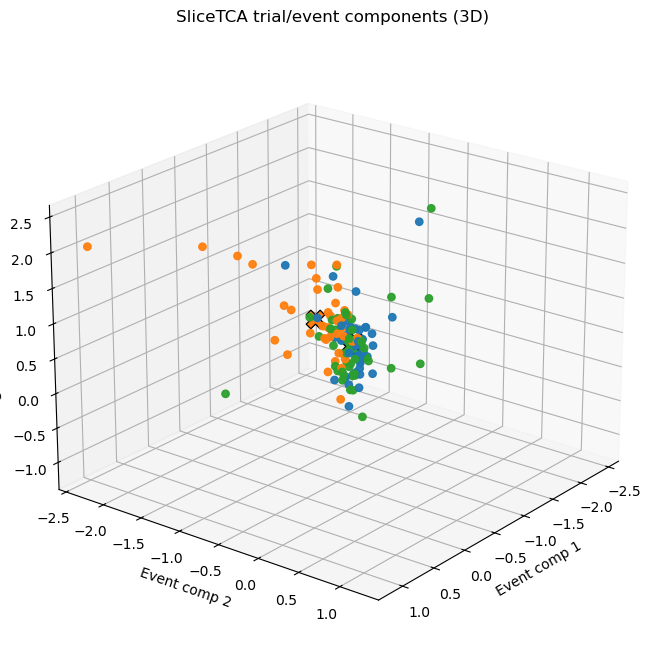

In [23]:
# Extract event factors (N, R) 
event_factors = get_event_factors_slicetca(components)  # shape (N, R)
print(event_factors.shape)

# DEFINE COLORS FOR NON-SORTED EVENTS
cmap = plt.colormaps["tab10"]
unique_arms_rew = np.unique(event_arm_ids_rewarded)
arm_to_color_rew = {arm_id: cmap(i % 10)[:3] for i, arm_id in enumerate(unique_arms_rew)}
event_colors = np.array([arm_to_color_rew[arm_id] for arm_id in event_arm_ids_rewarded])

# Plots in 3D using the same colors per event
coords_3d = plot_trial_components_3d_slicetca(components=components3n,
    event_colors=event_colors,    
    component_indices=(0, 1, 2),          
    event_arm_ids=event_arm_ids_rewarded,   
    save_path="~/plots/slicetca_trial_components_3d.png")

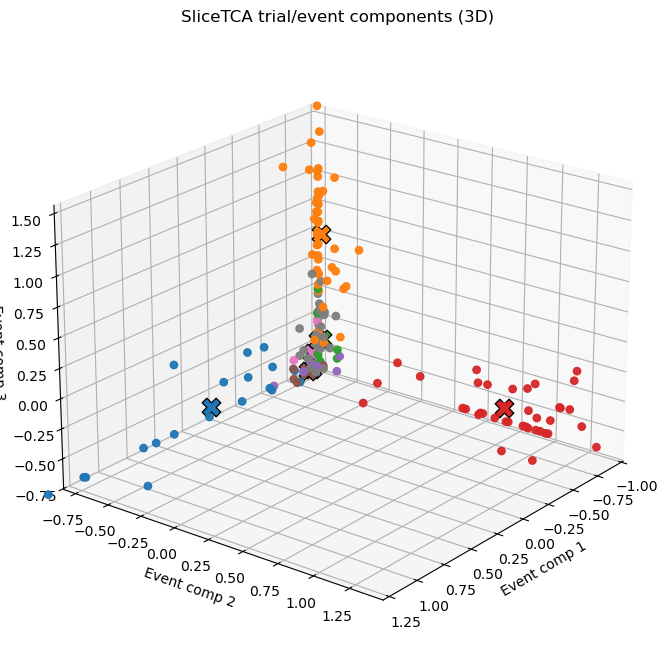

In [24]:
unique_arms = np.unique(event_arm_ids)
arm_to_color = {arm_id: cmap(i % 10)[:3] for i, arm_id in enumerate(unique_arms)}
event_colors_all = np.array([arm_to_color[arm_id] for arm_id in event_arm_ids])

coords_3d_hp_all = plot_trial_components_3d_slicetca(components=components100hp_all,
    event_colors=event_colors_all, component_indices=(0, 1, 2), event_arm_ids=event_arm_ids,   
    save_path="~/plots/slicetca_trial_components_3d_hp_all.png")

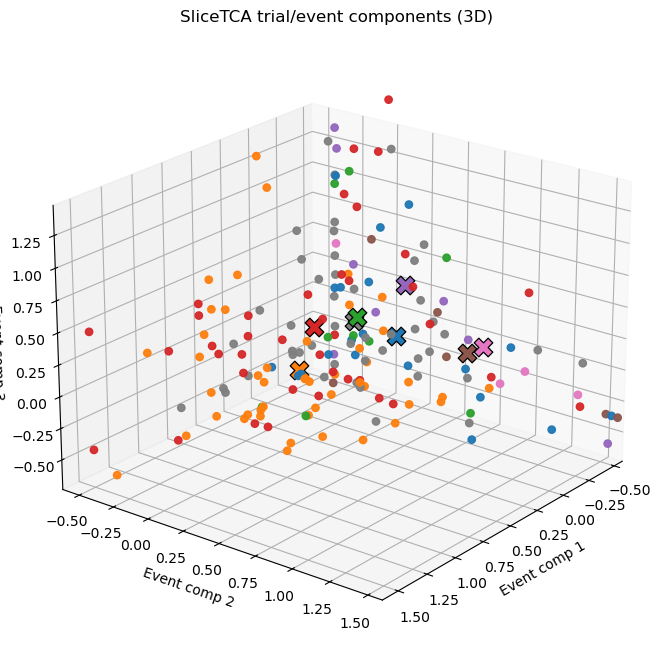

In [25]:
coords_3d_pp_all = plot_trial_components_3d_slicetca(components=components100pp_all,
    event_colors=event_colors_all, component_indices=(0, 1, 2), event_arm_ids=event_arm_ids,   
    save_path="~/plots/slicetca_trial_components_3d_pp_all.png")

In [26]:
# pip install plotly
import numpy as np
import plotly.graph_objects as go

def rgb01_to_rgb255(colors):
    # convierte [(r,g,b) 0..1] -> ["rgb(r,g,b)"]
    return [f"rgb({int(c[0]*255)},{int(c[1]*255)},{int(c[2]*255)})" for c in np.asarray(colors)]

def plot_trial_components_3d_plotly(coords_3d, event_colors, title="SliceTCA trial components (3D)"):
    cols = rgb01_to_rgb255(event_colors)
    fig = go.Figure(data=[go.Scatter3d(x=coords_3d[:,0], y=coords_3d[:,1], z=coords_3d[:,2],
        mode="markers", marker=dict(size=4, opacity=0.95, color=cols))])
    fig.update_layout(title=title, scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z", aspectmode="data"),
        margin=dict(l=0, r=0, t=40, b=0))
    fig.show()

In [27]:
plot_trial_components_3d_plotly(coords_3d, event_colors)

In [28]:
plot_trial_components_3d_plotly(coords_3d_hp_all, event_colors_all)

In [29]:
plot_trial_components_3d_plotly(coords_3d_pp_all, event_colors_all)

In [30]:
# plot components with colors by time (event id order)
# pip install plotly
import numpy as np
import plotly.graph_objects as go

def plot_trial_components_3d_plotly_gradient(coords_3d: np.ndarray,
    order: np.ndarray | None = None,     # None -> use row order; or provide values/indices of length N
    colorscale: str = "Turbo",           # e.g., "Turbo", "Viridis", "Plasma", etc.
    reverse: bool = False,               # True -> hot→cold instead
    marker_size: int = 4,
    marker_opacity: float = 0.95,
    title: str = "SliceTCA trial components (3D, gradient by event order)",
    show_colorbar: bool = True,):
    """
    Plot 3D points with a cold→hot gradient by event order.

    Parameters
    ----------
    coords_3d : array (N, 3)
        3D coordinates for N events, already in your preferred plotting order.
    order : array-like (N,) or None
        - None: color by row index (0..N-1).
        - If you pass a numeric array, colors follow its *rank order*.
          (Ties handled stably; lower value = colder.)
        - If you pass a permutation of [0..N-1], colors follow that permutation order.
    colorscale : str
        Plotly colorscale name (e.g., "Turbo" gives strong cold→hot contrast).
    reverse : bool
        If True, invert the color mapping (hot→cold).
    """
    coords_3d = np.asarray(coords_3d)
    assert coords_3d.ndim == 2 and coords_3d.shape[1] == 3, "coords_3d must be (N, 3)"
    N = coords_3d.shape[0]

    # --- Build a [0,1] color value per point that reflects the desired order ---
    if order is None:
        ranks = np.arange(N, dtype=float)
    else:
        order = np.asarray(order)
        if order.shape[0] != N:
            raise ValueError("`order` must have the same length as coords_3d (N events).")

        # Case A: permutation of [0..N-1] -> use its position as rank
        if (order.dtype.kind in "iu") and np.array_equal(np.sort(order), np.arange(N)):
            inv = np.empty(N, dtype=int)
            inv[order] = np.arange(N)              # rank of each index in the permutation
            ranks = inv.astype(float)
        else:
            # Case B: arbitrary numeric values -> rank them (stable)
            ranks = np.empty(N, dtype=float)
            ranks[np.argsort(order, kind="stable")] = np.arange(N)

    if reverse:
        ranks = (N - 1) - ranks

    cvals = ranks / max(N - 1, 1)  # normalize to [0,1]

    # --- Plotly scatter3d with a continuous colorscale ---
    fig = go.Figure(data=[go.Scatter3d(x=coords_3d[:, 0], y=coords_3d[:, 1], z=coords_3d[:, 2], mode="markers",
        marker=dict(size=marker_size, opacity=marker_opacity, color=cvals,   # numeric values -> colorscale
            colorscale=colorscale, showscale=show_colorbar, colorbar=dict(title="event order<br>(cold → hot)") if show_colorbar else None,),)])

    fig.update_layout(title=title, scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z", aspectmode="data"),
        margin=dict(l=0, r=0, t=40, b=0))
    fig.show()

In [31]:
# color by the current row order (first cold → last hot)
plot_trial_components_3d_plotly_gradient(coords_3d)

In [32]:
plot_trial_components_3d_plotly_gradient(coords_3d_hp_all)